# Catanatron Shapley values

### Imports

In [1]:
import random
import gymnasium as gym
from pprint import pprint
from catanatron import Color,RandomPlayer
from catanatron.players.weighted_random import WeightedRandomPlayer, DevCardRandomPlayer, DoNothingRandomPlayer,CityRandomPlayer,SettlementRandomPlayer,LongestRoadRandomPlayer
from catanatron_gym.rewards import reward_function
from catanatron_gym.features import create_sample_vector, create_sample
from sklearn.model_selection import train_test_split

from catanatron.players.search import VictoryPointPlayer
from catanatron_gym.envs.catanatron_env import from_action_space
import gymnasium as gym
import numpy as np
from sb3_contrib.common.maskable.policies import MaskableActorCriticPolicy
from sb3_contrib.common.wrappers import ActionMasker
from sb3_contrib.ppo_mask import MaskablePPO

from stable_baselines3 import PPO
from catanatron_gym.features import create_sample_vector, get_feature_ordering,create_sample
from catanatron_gym.envs.catanatron_env import from_action_space
# FEATURES = get_feature_ordering
from pprint import pprint
import random
import pandas as pd
from shaprpy import explain
from catanatron_experimental.machine_learning.players.minimax import AlphaBetaPlayer
import matplotlib.pyplot as plt
# !pip install seaborn
import seaborn as sns
import torch
import torch.nn as nn
from torch import float32
import shap.shap
from torch.autograd import Variable
import re

## Functions

In [2]:
class sb3Wrapper(nn.Module):
    def __init__(self, model):
        super(sb3Wrapper,self).__init__()
        self.extractor = model.policy.mlp_extractor
        self.policy_net = model.policy.mlp_extractor.policy_net
        self.action_net = model.policy.action_net
        print(self.action_net)

    def forward(self,x):
        x = self.policy_net(x)
        x = self.action_net(x)
        return torch.tensor(torch.argmax(x,keepdim=True),dtype=torch.float64)


def mask_fn(env) -> np.ndarray:
    valid_actions = env.get_valid_actions()
    mask = np.zeros(env.action_space.n, dtype=np.float32)
    mask[valid_actions] = 1

    return np.array([bool(i) for i in mask])

def run_rl_agent(env_config, agent_path= "../logs/Catan_Baseline_rewards_Test/exp_001/latest_model_1000000_steps.zip"):
    # inits for data collection
    try:
        env = gym.make("catanatron_gym:catanatron-v1", env_config)  
        print("made env with config")
    except:
        env = gym.make("catanatron_gym:catanatron-v1")  
        print("made env without config")
    env = ActionMasker(env=env,action_mask_fn=mask_fn)
    observation, info = env.reset()

    model = MaskablePPO.load(path= agent_path,env=env)
    for _ in range(1000):
        action = model.predict(observation=observation,action_masks=mask_fn(env),deterministic=True)

        observation, reward, terminated, truncated, info = env.step(action[0])
        done = terminated or truncated
        if done:
            print(env.game.winning_color())
            observation, info = env.reset()
    # print(info)
    env.close()

def run_switch_agent(env_config, agent_path="./logs/Catan_Switch_Exp/exp_014/best_model.zip"):
    best_path = "../logs/Catan_Switch_Exp/exp_014/best_model.zip"
    latest_path = "../logs/Catan_Switch_Exp/exp_004/latest_model_1000000_steps.zip"
    obs_list = []
    info_list =[]
    action_list =[]
    record_list =[]
    data = []
    features = None
    try:
        env = gym.make("catanatron_gym:catanatron-switch-v1",config = env_config)
        print("made env using config")
    except:
        env = gym.make("catanatron_gym:catanatron-switch-v1")
        print('made env without config')

    observation, info = env.reset()
    model = PPO.load(path=agent_path,env=env)
    # print(env.p0.color)
    # print(model.policy)
    for ep in range(2):
        for step in range(1000):
            action = model.predict(observation=observation,deterministic=True)
            # obs_list.append(observation)
            # action_list.append(action)
            record = create_sample(env.game,env.p0.color)
            features =sorted(record.keys()) # get list of feature names in same order as observation
            data.append([ep,step,observation,action[0]])
            observation, reward, terminated, truncated, info = env.step(action[0])
            done = terminated or truncated
            if done:
                # pprint(vars(env))
                # print(done)
                # print(env.game.winning_color())
                # print(env.game.state.player_state)
                # print(info)
                info_list.append(info)
                observation, info = env.reset()
                break
    # print(info)
    env.close()
    # print(record_list)
    return data, info_list, features

def prep_data(data:pd.DataFrame,featrues):
    df = data[['obs','action']].copy()
    df[featrues] = pd.DataFrame(data.obs.tolist(), index = data.index)
    print(df)
    #find len of final ep
    #TODO find length of winning episode
    # len(df[df.ep ==df.ep.max()])

    dfx_train, dfx_test, dfy_train, dfy_test = train_test_split(df[featrues],df['action'],random_state=42, test_size=len(data[data.ep ==data.ep.max()]))
    return dfx_train, dfx_test, dfy_train, dfy_test

def shapley(env_config= None, agent_path = "./logs/Catan_Switch_Exp/exp_014/best_model.zip"):
    data, info_list, catan_featrues = run_switch_agent(env_config=env_config, agent_path=agent_path)
    features = ["ep","step",'obs', 'action']
    df = pd.DataFrame(data=data, columns=features)
    print(str(catan_featrues))

    #format data
    dfx_train, dfx_test, dfy_train, dfy_test = prep_data(df,catan_featrues)

    #load_model
    
    model = PPO.load(path =agent_path, device='cuda')
    print(type(model))
    model = sb3Wrapper(model)
    print(type(model))
    print(model)
    # print(model.action_net)
    # print(dfy_train.mean())
    # model.predict()[0]
    # explainer = shap.shap.DeepExplainer(model,dfx_train,framework='pytorch')
    state_log = np.array(df['obs'].values.tolist())
    tensor_data = torch.from_numpy(state_log).to('cuda')
    print(tensor_data)
    print(tensor_data.shape)
    # f = lambda x: model.forward(Variable(torch.from_numpy(x),requires_grad=False).to(float32).cuda()).detach().cpu().numpy()
    # explainer = shap.shap.KernelExplainer(f, state_log)
    # shap_vals= explainer.shap_values(state_log)
    # state_log = np.array(df['obs'].values.tolist())
    tensor_data = torch.FloatTensor(state_log).to('cuda')
    print(tensor_data[0])
    print(model.forward(tensor_data[0]).dtype)
    print(df['action'][0])
    explainer = shap.shap.DeepExplainer(model,tensor_data)

    shap_values = explainer.shap_values(data,check_additivity=True)

    return shap_values

def groupshap(env_config= None, explainer_type:str ="kernel", agent_path = "./logs/Catan_Switch_Exp/exp_014/best_model.zip"):
    data, info_list, catan_featrues = run_switch_agent(env_config=env_config, agent_path=agent_path)
    features = ["ep","step",'obs', 'action']
    df = pd.DataFrame(data=data, columns=features)

    #format data
    dfx_train, dfx_test, dfy_train, dfy_test = prep_data(df,catan_featrues)

    #load_model
    model = PPO.load(path =agent_path, device='cuda')
    print(dfy_train.mean())
    # model.predict()[0]

    df_shapley, pred_explain, internal, timing ,MSEv= explain(
        model = model,
        x_train = dfx_train,
        x_explain = dfx_test,
        approach = 'independence',
        # n_combinations=2**len(catan_featrues),
        n_samples=50,
        n_combinations=10000,
        n_batches=30,
        predict_model= lambda m,x: m.predict(x,deterministic =True)[0],
        prediction_zero = dfy_train.mean().item(),
    )
    return df_shapley, pred_explain, internal, timing, MSEv


def test_shap():
    from sklearn.ensemble import RandomForestRegressor
    from shaprpy import explain
    from shaprpy.datasets import load_california_housing

    dfx_train, dfx_test, dfy_train, dfy_test = load_california_housing()

    ## Fit model
    model = RandomForestRegressor()
    model.fit(dfx_train, dfy_train.values.flatten())

    ## Shapr
    df_shapley, pred_explain, internal, timing ,MSEv= explain(
        model = model,
        x_train = dfx_train,
        x_explain = dfx_test,
        approach = 'empirical',
        prediction_zero = dfy_train.mean().item(),
        verbose=2
    )
    print(df_shapley)



## Normal RL Agent

## Switch Agent

In [3]:
# get runs
config={"enemies": [AlphaBetaPlayer(Color.RED,depth=1)]}
# config={"enemies": [LongestRoadRandomPlayer(Color.RED)]}
data, game_info, featrues = run_switch_agent(env_config= config)
# df_shapley, pred_explain, internal, timing, MSEv = groupshap(env_config=config)
# shap_vals = shapley(env_config=config)

running switch env
{'enemies': [AlphaBetaPlayer:RED(depth=1,value_fn=base_fn,prunning=False)]}
made env using config
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/home/alex/anaconda3/envs/catanatron/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.game to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.game` for environment variables or `env.get_wrapper_attr('game')` that will search the reminding wrappers.
  logger.warn(
/home/alex/anaconda3/envs/catanatron/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.p0 to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.p0` for environment variables or `env.get_wrapper_attr('p0')` that will search the reminding wrappers.
  logger.warn(


In [4]:
print(featrues)
bank_features = re.compile(".*BANK")
edge_features = re.compile(".*EDGE")
P0_roads = re.compile(r'EDGE\([0-9]+,\s+[0-9]+\)_P0_ROAD')
P1_roads = re.compile(r'EDGE\([0-9]+,\s+[0-9]+\)_P1_ROAD')
tile_features = re.compile(".*TILE")
node_features = re.compile(".*NODE")
P0_settlements = re.compile(r'NODE[A-Za-z0-9_]+_P0_SETTLEMENT')
P1_settlements = re.compile(r'NODE[A-Za-z0-9_]+_P1_SETTLEMENT')
P0_cities = re.compile(r'NODE[A-Za-z0-9_]+_P0_CITY')
P1_cities = re.compile(r'NODE[A-Za-z0-9_]+_P1_CITY')
port_features = re.compile(".*PORT")
rolled_robber_features = re.compile("(.*IS_DISCARDING)|(.*IS_MOVING_ROBBER)")
rolled_feature = re.compile(".*HAS_ROLLED")
p0_played_dev_in_turn = re.compile(r'P0_HAS_PLAYED_DEVELOPMENT_CARD_IN_TURN')
p0_vps = re.compile(".*P0_ACTUAL_VPS|.*P0_PUBLIC_VPS")
p0_hand = re.compile(r'P0_[A-Za-z0-9_]+_IN_HAND')
p1_hand = re.compile(r'P1_[A-Za-z0-9_]+_IN_HAND')
p0_has_army = re.compile(r'P0_HAS_ARMY')
p0_has_road = re.compile(r'P0_HAS_ROAD')
p1_has_army = re.compile(r'P1_HAS_ARMY')
p1_has_road = re.compile(r'P1_HAS_ROAD')
p0_pieces= re.compile(r'P0_[A-Za-z0-9_]+_LEFT')
p1_pieces= re.compile(r'P1_[A-Za-z0-9_]+_LEFT')
p0_devs_played = re.compile(r'P0_[A-Za-z0-9_]+_PLAYED$')
p1_devs_played = re.compile(r'P1_[A-Za-z0-9_]+_PLAYED$')
p1_public_vps = re.compile(r'P1_PUBLIC_VPS')
p0_longest_road_length = re.compile(r'P0_LONGEST_ROAD_LENGTH')
p1_longest_road_length = re.compile(r'P1_LONGEST_ROAD_LENGTH')

print(list(filter(P0_roads.match, featrues)))
print(list(filter(P1_roads.match, featrues)))
print(list(filter(P0_settlements.match, featrues)))
print(list(filter(P1_settlements.match, featrues)))
print(list(filter(P0_cities.match, featrues)))
print(list(filter(P1_cities.match, featrues)))



print('\n')
print(list(filter(bank_features.match, featrues)))
print(list(filter(edge_features.match, featrues)))
print(list(filter(tile_features.match, featrues)))
print(list(filter(node_features.match, featrues)))
print(list(filter(port_features.match, featrues)))
print(list(filter(rolled_robber_features.match, featrues)))
print(list(filter(rolled_feature.match, featrues)))
print(list(filter(p0_played_dev_in_turn.match, featrues)))
print(list(filter(p0_vps.match, featrues)))
print(list(filter(p0_hand.match, featrues)))
print(list(filter(p1_hand.match, featrues)))
print(list(filter(p0_has_army.match, featrues)))
print(list(filter(p1_has_army.match, featrues)))
print(list(filter(p0_has_road.match, featrues)))
print(list(filter(p1_has_road.match, featrues)))
print(list(filter(p0_pieces.match, featrues)))
print(list(filter(p1_pieces.match, featrues)))
print(list(filter(p0_devs_played.match, featrues)))
print(list(filter(p1_devs_played.match, featrues)))
print(list(filter(p1_public_vps.match, featrues)))
print(list(filter(p0_longest_road_length.match, featrues)))
print(list(filter(p1_longest_road_length.match, featrues)))

['BANK_BRICK', 'BANK_DEV_CARDS', 'BANK_ORE', 'BANK_SHEEP', 'BANK_WHEAT', 'BANK_WOOD', 'EDGE(0, 1)_P0_ROAD', 'EDGE(0, 1)_P1_ROAD', 'EDGE(0, 20)_P0_ROAD', 'EDGE(0, 20)_P1_ROAD', 'EDGE(0, 5)_P0_ROAD', 'EDGE(0, 5)_P1_ROAD', 'EDGE(1, 2)_P0_ROAD', 'EDGE(1, 2)_P1_ROAD', 'EDGE(1, 6)_P0_ROAD', 'EDGE(1, 6)_P1_ROAD', 'EDGE(10, 11)_P0_ROAD', 'EDGE(10, 11)_P1_ROAD', 'EDGE(10, 29)_P0_ROAD', 'EDGE(10, 29)_P1_ROAD', 'EDGE(11, 12)_P0_ROAD', 'EDGE(11, 12)_P1_ROAD', 'EDGE(11, 32)_P0_ROAD', 'EDGE(11, 32)_P1_ROAD', 'EDGE(12, 13)_P0_ROAD', 'EDGE(12, 13)_P1_ROAD', 'EDGE(13, 14)_P0_ROAD', 'EDGE(13, 14)_P1_ROAD', 'EDGE(13, 34)_P0_ROAD', 'EDGE(13, 34)_P1_ROAD', 'EDGE(14, 15)_P0_ROAD', 'EDGE(14, 15)_P1_ROAD', 'EDGE(14, 37)_P0_ROAD', 'EDGE(14, 37)_P1_ROAD', 'EDGE(15, 17)_P0_ROAD', 'EDGE(15, 17)_P1_ROAD', 'EDGE(16, 18)_P0_ROAD', 'EDGE(16, 18)_P1_ROAD', 'EDGE(16, 21)_P0_ROAD', 'EDGE(16, 21)_P1_ROAD', 'EDGE(17, 18)_P0_ROAD', 'EDGE(17, 18)_P1_ROAD', 'EDGE(17, 39)_P0_ROAD', 'EDGE(17, 39)_P1_ROAD', 'EDGE(18, 40)_P0_ROA

In [7]:
print(featrues)
bank_features = re.compile(".*BANK")
edge_features = re.compile(".*EDGE")
tile_features = re.compile(".*TILE")
node_features = re.compile(".*NODE")
port_features = re.compile(".*PORT")
rolled_robber_features = re.compile("(.*IS_DISCARDING)|(.*IS_MOVING_ROBBER)")
rolled_feature = re.compile(".*HAS_ROLLED")
p0_played_dev_in_turn = re.compile(r'P0_HAS_PLAYED_DEVELOPMENT_CARD_IN_TURN')
p0_vps = re.compile(".*P0_ACTUAL_VPS|.*P0_PUBLIC_VPS")
p0_hand = re.compile(r'P0_[A-Za-z0-9_]+_IN_HAND')
p1_hand = re.compile(r'P1_[A-Za-z0-9_]+_IN_HAND')
p0_has_army = re.compile(r'P0_HAS_ARMY')
p0_has_road = re.compile(r'P0_HAS_ROAD')
p1_has_army = re.compile(r'P1_HAS_ARMY')
p1_has_road = re.compile(r'P1_HAS_ROAD')
p0_pieces= re.compile(r'P0_[A-Za-z0-9_]+_LEFT')
p1_pieces= re.compile(r'P1_[A-Za-z0-9_]+_LEFT')
p0_devs_played = re.compile(r'P0_[A-Za-z0-9_]+_PLAYED$')
p1_devs_played = re.compile(r'P1_[A-Za-z0-9_]+_PLAYED')
p1_public_vps = re.compile(r'P1_PUBLIC_VPS')
p0_longest_road_length = re.compile(r'P0_LONGEST_ROAD_LENGTH')
p1_longest_road_length = re.compile(r'P1_LONGEST_ROAD_LENGTH')


print(list(filter(bank_features.match, featrues)))
print(list(filter(edge_features.match, featrues)))
print(list(filter(tile_features.match, featrues)))
print(list(filter(node_features.match, featrues)))
print(list(filter(port_features.match, featrues)))
print(list(filter(rolled_robber_features.match, featrues)))
print(list(filter(rolled_feature.match, featrues)))
print(list(filter(p0_played_dev_in_turn.match, featrues)))
print(list(filter(p0_vps.match, featrues)))
print(list(filter(p0_hand.match, featrues)))
print(list(filter(p1_hand.match, featrues)))
print(list(filter(p0_has_army.match, featrues)))
print(list(filter(p1_has_army.match, featrues)))
print(list(filter(p0_has_road.match, featrues)))
print(list(filter(p1_has_road.match, featrues)))
print(list(filter(p0_pieces.match, featrues)))
print(list(filter(p1_pieces.match, featrues)))
print(list(filter(p0_devs_played.match, featrues)))
print(list(filter(p1_devs_played.match, featrues)))
print(list(filter(p1_public_vps.match, featrues)))
print(list(filter(p0_longest_road_length.match, featrues)))
print(list(filter(p1_longest_road_length.match, featrues)))

bank_features =list(filter(bank_features.match, featrues))
edge_features =list(filter(edge_features.match, featrues))
p0_road_features = list(filter(P0_roads.match, featrues))
p1_road_features = list(filter(P1_roads.match, featrues))
tile_features =list(filter(tile_features.match, featrues))
node_features=list(filter(node_features.match, featrues))
P0_settlement_features= list(filter(P0_settlements.match, featrues))
P1_settlement_features= list(filter(P1_settlements.match, featrues))
P0_city_features= list(filter(P0_cities.match, featrues))
P1_city_features= list(filter(P1_cities.match, featrues))
port_features=list(filter(port_features.match, featrues))
rolled_robber_features=list(filter(rolled_robber_features.match, featrues))
rolled_feature=list(filter(rolled_feature.match, featrues))
p0_played_dev_in_turn =list(filter(p0_played_dev_in_turn.match, featrues))
p0_vps = list(filter(p0_vps.match, featrues))
p0_hand = list(filter(p0_hand.match, featrues))
p1_hand =list(filter(p1_hand.match, featrues))
p0_has_army =list(filter(p0_has_army.match, featrues))
p1_has_army=list(filter(p1_has_army.match, featrues))
p0_has_road=list(filter(p0_has_road.match, featrues))
p1_has_road=list(filter(p1_has_road.match, featrues))
p0_pieces =list(filter(p0_pieces.match, featrues))
p1_pieces=list(filter(p1_pieces.match, featrues))
p0_devs_played =list(filter(p0_devs_played.match, featrues))
p1_devs_played =list(filter(p1_devs_played.match, featrues))
p1_public_vps=list(filter(p1_public_vps.match, featrues))
p0_longest_road_length=list(filter(p0_longest_road_length.match, featrues))
p1_longest_road_length=list(filter(p1_longest_road_length.match, featrues))


# as a group
strat_group ={
    "bank": bank_features,
    "p0_roads": p0_road_features, 
    "p1_roads": p1_road_features,
    "tile_features": tile_features,
    "p0_settlements": P0_settlement_features,
    "p1_settlements": P1_settlement_features,
    "p0_cities": P0_city_features,
    "p1_cities": P1_city_features,
    "port_features":port_features,
    "rolled_robber_features": rolled_robber_features,
    "rolled_feature": rolled_feature,
    "p0_played_dev_in_turn": p0_played_dev_in_turn,
    "p0_vps": p0_vps,
    "p1_public_vps": p1_public_vps,
    "p0_hand": p0_hand,
    "p1_hand": p1_hand,
    "p0_has_army": p0_has_army,
    "p0_has_longest_road": p0_has_road,
    "p0_longest_road_length": p0_longest_road_length,
    "p1_has_army":p1_has_army,
    "p1_has_longest_road": p1_has_road,
    "p1_longest_road_length":p1_longest_road_length,
    "p0_pieces": p0_pieces,
    "p1_pieces":p1_pieces,
    "p0_devs_played":p0_devs_played,
    "p1_devs_played": p1_devs_played,
}
small_strat_group ={
    "bank": bank_features,
    "p0_roads": p0_road_features + p0_longest_road_length + p0_has_road, 
    "p1_roads": p1_road_features + p1_longest_road_length + p1_has_road,
    "tile_features": tile_features + port_features,
    "p0_settlements": P0_settlement_features,
    "p1_settlements": P1_settlement_features,
    "p0_cities": P0_city_features,
    "p1_cities": P1_city_features,
    "rolled_robber_features": rolled_robber_features,
    "rolled_feature": rolled_feature,
    "p0_vps": p0_vps,
    "p1_public_vps": p1_public_vps + p1_has_army,
    "p0_hand": p0_hand,
    "p0_has_army": p0_has_army,
    "p0_pieces": p0_pieces,
    "p1_pieces_and_hand":p1_pieces+p1_hand,
    "p0_devs_played":p0_devs_played+p0_played_dev_in_turn,
    "p1_devs_played": p1_devs_played,
}

group_1 = {
    "bank": bank_features,
    "edge_features": edge_features,
    "tile_features": tile_features,
    "node_features": node_features,
    "port_features":port_features,
    "rolled_robber_features": rolled_robber_features,
    "rolled_feature": rolled_feature,
    "p0_played_dev_in_turn": p0_played_dev_in_turn,
    "p0_vps": p0_vps,
    "p1_public_vps": p1_public_vps,
    "p0_hand": p0_hand,
    "p1_hand": p1_hand,
    "p0_has_army": p0_has_army,
    "p0_has_longest_road": p0_has_road,
    "p0_longest_road_length": p0_longest_road_length,
    "p1_has_army":p1_has_army,
    "p1_has_longest_road": p1_has_road,
    "p1_longest_road_length":p1_longest_road_length,
    "p0_pieces": p0_pieces,
    "p1_pieces":p1_pieces,
    "p0_devs_played":p0_devs_played,
    "p1_devs_played": p1_devs_played,
}

group_2 ={
    "board_features": bank_features + tile_features + port_features, 
    "graph_features": node_features + edge_features,
    "turn_features": rolled_feature + rolled_robber_features+p0_played_dev_in_turn,
    "p0_vps": p0_vps + p0_has_army + p0_has_road, #TODO Get the VP_in hand
    "p1_vps": p1_public_vps + p1_has_army + p1_has_road,
    "p0_hand_and_pieces": p0_hand + p0_pieces + p0_longest_road_length,
    "p1_hand_and_pieces": p1_hand + p1_pieces +p1_longest_road_length,
    "p0_dev_cards_played": p0_devs_played,
    "p1_dev_cards_played": p1_devs_played,
}
group_3 ={
    "board_features": bank_features + tile_features + port_features, 
    "graph_features": node_features + edge_features,
    "turn_features": rolled_feature + rolled_robber_features+p0_played_dev_in_turn,
    "p0_vps": p0_vps + p0_has_army + p0_has_road+ p0_hand + p0_pieces + p0_longest_road_length + p0_devs_played,
    "p1_vps": p1_public_vps + p1_has_army + p1_has_road + p1_hand + p1_pieces +p1_longest_road_length + p1_devs_played,
}
print(group_1)
def check_elements_in_dict(input_list, dict_of_lists):
    for element in input_list:
        found = False
        for key, value_list in dict_of_lists.items():
            if element in value_list:
                found = True
        if not found:
            return False
    return True

check_elements_in_dict(featrues,group_3)

def total_elements_in_dict_of_lists(dict_of_lists):
    total_elements = sum(len(value_list) for value_list in dict_of_lists.values())
    return total_elements

total_elements_in_dict_of_lists(strat_group)
print(len(featrues))

['BANK_BRICK', 'BANK_DEV_CARDS', 'BANK_ORE', 'BANK_SHEEP', 'BANK_WHEAT', 'BANK_WOOD', 'EDGE(0, 1)_P0_ROAD', 'EDGE(0, 1)_P1_ROAD', 'EDGE(0, 20)_P0_ROAD', 'EDGE(0, 20)_P1_ROAD', 'EDGE(0, 5)_P0_ROAD', 'EDGE(0, 5)_P1_ROAD', 'EDGE(1, 2)_P0_ROAD', 'EDGE(1, 2)_P1_ROAD', 'EDGE(1, 6)_P0_ROAD', 'EDGE(1, 6)_P1_ROAD', 'EDGE(10, 11)_P0_ROAD', 'EDGE(10, 11)_P1_ROAD', 'EDGE(10, 29)_P0_ROAD', 'EDGE(10, 29)_P1_ROAD', 'EDGE(11, 12)_P0_ROAD', 'EDGE(11, 12)_P1_ROAD', 'EDGE(11, 32)_P0_ROAD', 'EDGE(11, 32)_P1_ROAD', 'EDGE(12, 13)_P0_ROAD', 'EDGE(12, 13)_P1_ROAD', 'EDGE(13, 14)_P0_ROAD', 'EDGE(13, 14)_P1_ROAD', 'EDGE(13, 34)_P0_ROAD', 'EDGE(13, 34)_P1_ROAD', 'EDGE(14, 15)_P0_ROAD', 'EDGE(14, 15)_P1_ROAD', 'EDGE(14, 37)_P0_ROAD', 'EDGE(14, 37)_P1_ROAD', 'EDGE(15, 17)_P0_ROAD', 'EDGE(15, 17)_P1_ROAD', 'EDGE(16, 18)_P0_ROAD', 'EDGE(16, 18)_P1_ROAD', 'EDGE(16, 21)_P0_ROAD', 'EDGE(16, 21)_P1_ROAD', 'EDGE(17, 18)_P0_ROAD', 'EDGE(17, 18)_P1_ROAD', 'EDGE(17, 39)_P0_ROAD', 'EDGE(17, 39)_P1_ROAD', 'EDGE(18, 40)_P0_ROA

In [27]:
features = ["ep","step",'obs', 'action']
df = pd.DataFrame(data=data, columns=features)
# print(df['obs'][df['ep']==0][68])
len(df[df.ep ==df.ep.max()])

377

In [22]:
len(game_info[0]['all_actions_played'])
# print(game_info)
win_count =0
has_road_count =0
op_has_road_count = 0
for game in game_info:
    if game['game_stats']['p0_winning']:
        win_count +=1
    if game['p0_stats']['p0_has_road']:
        has_road_count +=1
    if game['p1_stats']['p1_has_road']:
        op_has_road_count +=1
    print(game["p0_stats"])
    print(game['p1_stats'])
print(sum(game["p0_stats"]['p0_actual_vp']for game in game_info)/len(game_info))
print(win_count, has_road_count,op_has_road_count)

{'p0_vp': 4, 'p0_actual_vp': 5, 'p0_has_road': False, 'p0_has_army': False, 'p0_longest_road_length': 4, 'p0_cities': 1, 'p0_settlements': 2}
{'p1_vp': 6, 'p1_actual_vp': 10, 'p1_has_road': True, 'p1_has_army': True, 'p1_longest_road_length': 5, 'p1_cities': 0, 'p1_settlements': 2}
{'p0_vp': 10, 'p0_actual_vp': 10, 'p0_has_road': True, 'p0_has_army': True, 'p0_longest_road_length': 7, 'p0_cities': 2, 'p0_settlements': 2}
{'p1_vp': 2, 'p1_actual_vp': 5, 'p1_has_road': False, 'p1_has_army': False, 'p1_longest_road_length': 6, 'p1_cities': 0, 'p1_settlements': 2}
{'p0_vp': 8, 'p0_actual_vp': 10, 'p0_has_road': True, 'p0_has_army': True, 'p0_longest_road_length': 8, 'p0_cities': 0, 'p0_settlements': 4}
{'p1_vp': 3, 'p1_actual_vp': 5, 'p1_has_road': False, 'p1_has_army': False, 'p1_longest_road_length': 7, 'p1_cities': 1, 'p1_settlements': 1}
{'p0_vp': 6, 'p0_actual_vp': 10, 'p0_has_road': True, 'p0_has_army': True, 'p0_longest_road_length': 5, 'p0_cities': 0, 'p0_settlements': 2}
{'p1_vp':

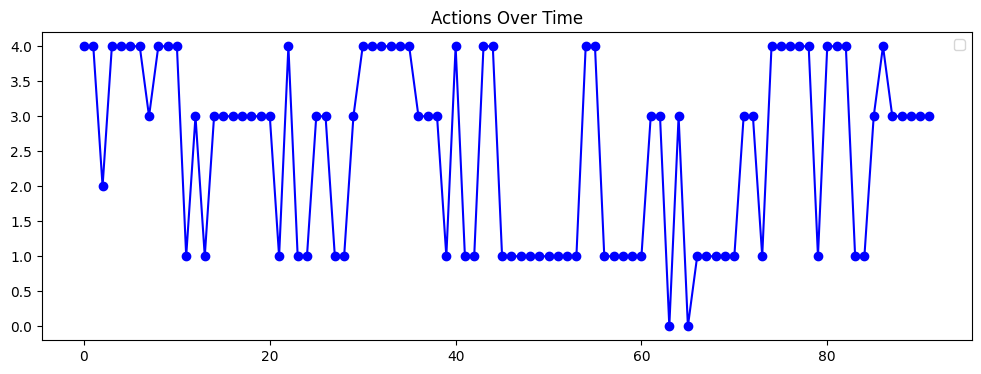

In [121]:
temp_df = df[df['ep']==3]
plt.figure(figsize=(12, 4))
plt.plot(temp_df['step'], temp_df['action'], marker='o', linestyle='-', color='b')
plt.legend([])
plt.title('Actions Over Time')
plt.show()

In [92]:
game_info[3]

{'game_stats': {'actions_count': 56, 'num_turns': 46, 'p0_winning': True},
 'p0_stats': {'p0_vp': 10,
  'p0_actual_vp': 10,
  'p0_has_road': True,
  'p0_has_army': False,
  'p0_longest_road_length': 5,
  'p0_cities': 4,
  'p0_settlements': 0},
 'p1_stats': {'p1_vp': 2,
  'p1_actual_vp': 2,
  'p1_has_road': False,
  'p1_has_army': False,
  'p1_longest_road_length': 2,
  'p1_cities': 0,
  'p1_settlements': 2},
 'all_actions_played': [Action(color=<Color.RED: 'RED'>, action_type=<ActionType.BUILD_SETTLEMENT: 'BUILD_SETTLEMENT'>, value=16),
  Action(color=<Color.RED: 'RED'>, action_type=<ActionType.BUILD_ROAD: 'BUILD_ROAD'>, value=(16, 21)),
  Action(color=<Color.BLUE: 'BLUE'>, action_type=<ActionType.BUILD_SETTLEMENT: 'BUILD_SETTLEMENT'>, value=53),
  Action(color=<Color.BLUE: 'BLUE'>, action_type=<ActionType.BUILD_ROAD: 'BUILD_ROAD'>, value=(52, 53)),
  Action(color=<Color.BLUE: 'BLUE'>, action_type=<ActionType.BUILD_SETTLEMENT: 'BUILD_SETTLEMENT'>, value=26),
  Action(color=<Color.BLUE:

In [60]:
sns.barplot(data=temp_df,x='step',y='action')

TypeError: unhashable type: 'numpy.ndarray'

In [55]:
temp_df['step'].max()

102